In [62]:
import os
import ast
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

base_path = "/content/drive/MyDrive/800/data"
save_path = "/content/drive/MyDrive/800/"

discipline = ["Economics", "Astronomy", "Computer Science"]
ke_files = ["ECO_reference_ke_result.txt", "AS_reference_ke_result.txt", "CS_reference_ke_result.txt"]
cid_files = ["ECO_id_cid_yearly.txt", "AS_id_cid_yearly.txt", "CS_id_cid_yearly.txt"]
career_files = ["ECO_author_career_largethan10.txt", "AS_author_career_largethan10.txt", "CS_author_career_largethan10.txt"]
id_cid_files = ["ECO_id_cid_list_new.txt", "AS_id_cid_list_new.txt", "CS_id_cid_list_new.txt"]

# read ke files
ke_dict_list = []
for f in ke_files:
    file_path = os.path.join(base_path, f)
    fr = open(file_path, "r+")
    dict = eval(fr.read())
    ke_dict_list.append(dict)
    fr.close()

# read cid files
cke_dict_list = []
for f in cid_files:
    cke_dict = {}
    file_path = os.path.join(base_path, f)
    fr = open(file_path, "r+")
    for line in fr.readlines():
        paper_id, year, ke = line.split('\t')
        year = int(year)
        ke = float(ke)
        if paper_id not in cke_dict:
            cke_dict[paper_id] = []
        cke_dict[paper_id].append((year, ke))
    cke_dict_list.append(cke_dict)

# read career files
career_dict_list = []
young, middle, senior = [], [], []
for f in career_files:
    dis_young, dis_middle, dis_senior = [], [], []
    file_path = os.path.join(base_path, f)
    fr = open(file_path, "r+")
    dict = eval(fr.read())
    career_dict_list.append(dict)
    fr.close()
    for k, v in dict.items():
        if 10 <= v < 15:
            dis_young.append(k)
        elif 15 <= v < 30:
            dis_middle.append(k)
        else:
            dis_senior.append(k)
    young.append(dis_young)
    middle.append(dis_middle)
    senior.append(dis_senior)

# read id_cid files
author_papers_list = []
author_cite_papers_list = []
for i, f in enumerate(id_cid_files):
    author_papers_dict = {}
    author_cite_papers_dict = {}
    file_path = os.path.join(base_path, f)
    fr = open(file_path, "r+")
    for line in fr.readlines():
        cid_list, paper_id, year, authors = line.split('\t')
        cid_list = ast.literal_eval(cid_list)
        year = int(year)
        authors = ast.literal_eval(authors)
        authors = [str(a) for a in authors]
        for author in authors:
            if author not in career_dict_list[i]:
                continue
            if author not in author_papers_dict:
                author_papers_dict[author] = []
            if author not in author_cite_papers_dict:
                author_cite_papers_dict[author] = []
            author_papers_dict[author].append((paper_id, year))
            author_cite_papers_dict[author].extend(cid_list)
    for k, v in author_papers_dict.items():
        author_papers_dict[k] = sorted(v, key=lambda x: x[1])
    author_papers_list.append(author_papers_dict)
    author_cite_papers_list.append(author_cite_papers_dict)

# get author kca
author_year_kca_list = []
for i, author_papers_dict in enumerate(author_papers_list):
    author_year_kca_dict = {}
    for author in author_papers_dict.keys():
        author_year_kca_dict[author] = {}
        career_length = career_dict_list[i][author]
        start_year = author_papers_dict[author][0][1]
        for career_year in range(1, career_length + 1):
            author_year_kca_dict[author][career_year] = 0.0
        for paper_id, year in author_papers_dict[author]:
            author_year_kca_dict[author][year - start_year + 1] += ke_dict_list[i].get(paper_id, 0.0)
            ckes = cke_dict_list[i].get(paper_id, [])
            for cite_year, cke in ckes:
                if cite_year - year <= 10:
                    author_year_kca_dict[author][year - start_year + 1] += cke
    author_year_kca_list.append(author_year_kca_dict)


def get_es(author, author_year_kca_dict, start, end):
    kca_list = [author_year_kca_dict[author][year] for year in range(start, end)]
    sum_kca = sum(kca_list)
    if math.isclose(sum_kca, 0): return 0.0
    num = sum([kca_list[i] / sum_kca for i in range(len(kca_list))])
    return num / (end - start)

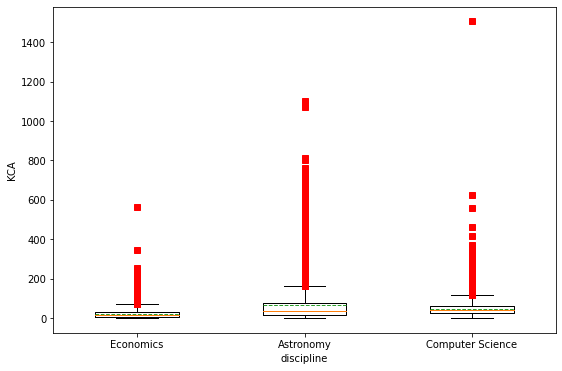

In [63]:
# for fig.1
author_kca_list = []
for author_year_kca in author_year_kca_list:
    author_kca = {}
    for k, v in author_year_kca.items():
        kca = sum(v.values())
        author_kca[k] = kca
    author_kca_list.append(author_kca)
all_kca = []
for author_kca_dict in author_kca_list:
    all_kca.append([v for v in author_kca_dict.values()])
fig = plt.figure(figsize=(9, 6))
plt.boxplot(all_kca,
            notch=False,
            sym='rs',
            showmeans=True,
            patch_artist=False,
            meanline=True,
            widths=0.5,
            vert=True)
plt.xticks([y+1 for y in range(len(all_kca))], discipline)
plt.xlabel('discipline')
plt.ylabel('KCA')
plt.savefig(save_path+"fig1.png", dpi=100)

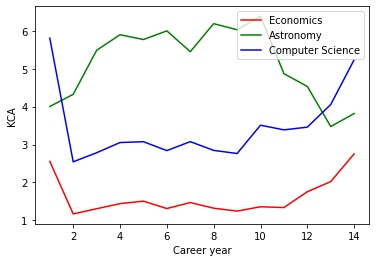

In [64]:
# for fig.2
# a (young)
x1 = [i for i in range(1, 15)]
eco_young_kca = []
as_young_kca = []
cs_young_kca = []
for year in x1:
    eco_kca_avg = as_kca_avg = cs_kca_avg = 0.0
    eco_count = as_count = cs_count = 0
    for author in young[0]:
        if year in author_year_kca_list[0][author]:
            eco_kca_avg += author_year_kca_list[0][author][year]
            eco_count += 1
    for author in young[1]:
        if year in author_year_kca_list[1][author]:
            as_kca_avg += author_year_kca_list[1][author][year]
            as_count += 1
    for author in young[2]:
        if year in author_year_kca_list[2][author]:
            cs_kca_avg += author_year_kca_list[2][author][year]
            cs_count += 1
    eco_kca_avg /= eco_count
    eco_young_kca.append(eco_kca_avg)
    as_kca_avg /= as_count
    as_young_kca.append(as_kca_avg)
    cs_kca_avg /= cs_count
    cs_young_kca.append(cs_kca_avg)

plt.plot(x1, eco_young_kca, color='r', label="Economics")
plt.plot(x1, as_young_kca, color='g', label="Astronomy")
plt.plot(x1, cs_young_kca, color='b', label="Computer Science")
plt.xlabel("Career year")
plt.ylabel("KCA")
plt.legend(loc="best")
plt.savefig("fig2(a).png")

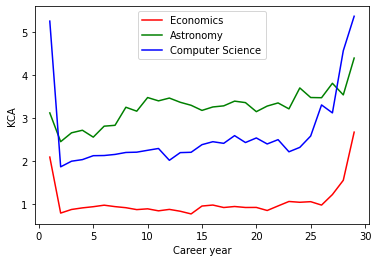

In [65]:
# b (middle)
x2 = [i for i in range(1, 30)]
eco_middle_kca = []
as_middle_kca = []
cs_middle_kca = []
for year in x2:
    eco_kca_avg = as_kca_avg = cs_kca_avg = 0.0
    eco_count = as_count = cs_count = 0
    for author in middle[0]:
        if year in author_year_kca_list[0][author]:
            eco_kca_avg += author_year_kca_list[0][author][year]
            eco_count += 1
    for author in middle[1]:
        if year in author_year_kca_list[1][author]:
            as_kca_avg += author_year_kca_list[1][author][year]
            as_count += 1
    for author in middle[2]:
        if year in author_year_kca_list[2][author]:
            cs_kca_avg += author_year_kca_list[2][author][year]
            cs_count += 1
    eco_kca_avg /= eco_count
    eco_middle_kca.append(eco_kca_avg)
    as_kca_avg /= as_count
    as_middle_kca.append(as_kca_avg)
    cs_kca_avg /= cs_count
    cs_middle_kca.append(cs_kca_avg)

plt.plot(x2, eco_middle_kca, color='r', label="Economics")
plt.plot(x2, as_middle_kca, color='g', label="Astronomy")
plt.plot(x2, cs_middle_kca, color='b', label="Computer Science")
plt.xlabel("Career year")
plt.ylabel("KCA")
plt.legend(loc="best")
plt.savefig(save_path+"fig2(b).png")

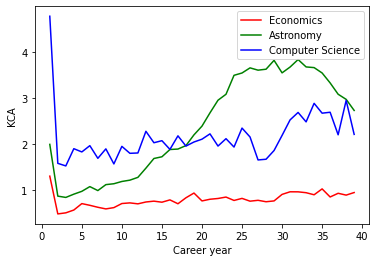

In [66]:
# c (senior)
x3 = [i for i in range(1, 40)]
eco_senior_kca = []
as_senior_kca = []
cs_senior_kca = []
for year in x3:
    eco_kca_avg = as_kca_avg = cs_kca_avg = 0.0
    eco_count = as_count = cs_count = 0
    for author in senior[0]:
        if year in author_year_kca_list[0][author]:
            eco_kca_avg += author_year_kca_list[0][author][year]
            eco_count += 1
    for author in senior[1]:
        if year in author_year_kca_list[1][author]:
            as_kca_avg += author_year_kca_list[1][author][year]
            as_count += 1
    for author in senior[2]:
        if year in author_year_kca_list[2][author]:
            cs_kca_avg += author_year_kca_list[2][author][year]
            cs_count += 1
    eco_kca_avg /= eco_count
    eco_senior_kca.append(eco_kca_avg)
    as_kca_avg /= as_count
    as_senior_kca.append(as_kca_avg)
    cs_kca_avg /= cs_count
    cs_senior_kca.append(cs_kca_avg)

plt.plot(x3, eco_senior_kca, color='r', label="Economics")
plt.plot(x3, as_senior_kca, color='g', label="Astronomy")
plt.plot(x3, cs_senior_kca, color='b', label="Computer Science")
plt.xlabel("Career year")
plt.ylabel("KCA")
plt.legend(loc="best")
plt.savefig(save_path+"fig2(c).png")

early-bloomer: 1283
mid_bloomers: 205
late_bloomers: 117
second_spring: 1974


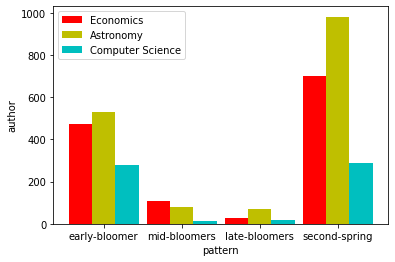

In [67]:
# for fig.3
late_bloomers_list = []
early_bloomers_list = []
mid_bloomers_list = []
second_spring_list = []
for i, dis_authors in enumerate(senior):
    late_bloomers = []
    early_bloomers = []
    mid_bloomers = []
    second_spring = []
    for author in dis_authors:
        a = get_es(author, author_year_kca_list[i], 1, 15)
        b = get_es(author, author_year_kca_list[i], 15, 30)
        c = get_es(author, author_year_kca_list[i], 30, career_dict_list[i][author])
        if a > b > c:
            early_bloomers.append(author)
        elif a < b < c:
            late_bloomers.append(author)
        elif b > a and b > c:
            mid_bloomers.append(author)
        else:
            second_spring.append(author)
    late_bloomers_list.append(late_bloomers)
    early_bloomers_list.append(early_bloomers)
    mid_bloomers_list.append(mid_bloomers)
    second_spring_list.append(second_spring)

eco_data = [len(early_bloomers_list[0]), len(mid_bloomers_list[0]), len(late_bloomers_list[0]), len(second_spring_list[0])]
as_data = [len(early_bloomers_list[1]), len(mid_bloomers_list[1]), len(late_bloomers_list[1]), len(second_spring_list[1])]
cs_data = [len(early_bloomers_list[2]), len(mid_bloomers_list[2]), len(late_bloomers_list[2]), len(second_spring_list[2])]
x = np.arange(4)
total_width, n = 0.9, 3
width = total_width / n
x = x - (total_width - width) / 2
plt.bar(x, eco_data, color="r", width=width, label='Economics')
plt.bar(x + width, as_data, color="y", width=width, label='Astronomy')
plt.bar(x + 2 * width, cs_data, color="c", width=width, label='Computer Science')
plt.xlabel("pattern")
plt.ylabel("author")
plt.legend(loc="best")
plt.xticks([0, 1, 2, 3], ["early-bloomer", "mid-bloomers", "late-bloomers", "second-spring"])
plt.savefig(save_path+"fig3.png")

print("early-bloomer:",len(early_bloomers_list[0])+len(early_bloomers_list[1])+len(early_bloomers_list[2]))
print("mid_bloomers:",len(mid_bloomers_list[0])+len(mid_bloomers_list[1])+len(mid_bloomers_list[2]))
print("late_bloomers:",len(late_bloomers_list[0])+len(late_bloomers_list[1])+len(late_bloomers_list[2]))
print("second_spring:",len(second_spring_list[0])+len(second_spring_list[1])+len(second_spring_list[2]))

[eb_kca]  max: 61.202299866473 min: 34.96348598715348 mean: 52.20012239722007 middle: 60.434581338033716
[mb_kca]  max: 26.105677256798256 min: 13.266415505022568 mean: 17.75251042730055 middle: 13.885438520080827
[lb_kca]  max: 83.0802887187459 min: 15.892345085578777 mean: 48.69036697849007 middle: 47.09846713114554
[ss_kca]  max: 94.99714223479205 min: 28.319398353133682 mean: 71.10498693840873 middle: 89.99842022730046
early bloomer and mid bloomer t value: 3.595316, pvalue: 0.022853
mid bloomer and late bloomer t value: -1.558045, pvalue: 0.194222
early bloomer and late bloomer t value: 0.165242, pvalue: 0.876769
early bloomer and second spring t value: -0.818049, pvalue: 0.459259
mid bloomer and second spring t value: -2.442305, pvalue: 0.071032
second spring and late bloomer t value: 0.774970, pvalue: 0.481620


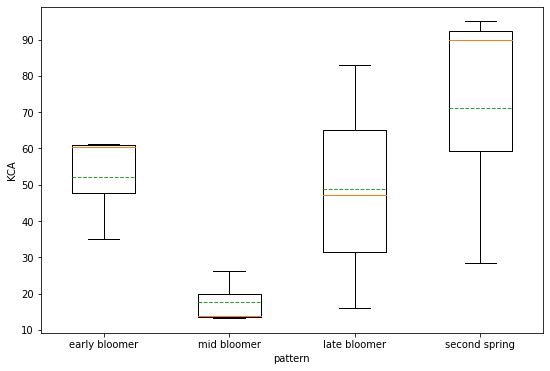

In [68]:
# for fig.4
eb_kcas = []
mb_kcas = []
lb_kcas = []
ss_kcas = []
for i in range(3):
    eb_kca = mb_kca = lb_kca = ss_kca = 0.0
    for author in early_bloomers_list[i]:
        eb_kca += author_kca_list[i][author]
    for author in mid_bloomers_list[i]:
        mb_kca += author_kca_list[i][author]
    for author in late_bloomers_list[i]:
        lb_kca += author_kca_list[i][author]
    for author in second_spring_list[i]:
        ss_kca += author_kca_list[i][author]
    eb_kca /= len(early_bloomers_list[i])
    mb_kca /= len(mid_bloomers_list[i])
    lb_kca /= len(late_bloomers_list[i])
    ss_kca /= len(second_spring_list[i])
    eb_kcas.append(eb_kca)
    mb_kcas.append(mb_kca)
    lb_kcas.append(lb_kca)
    ss_kcas.append(ss_kca)
all_kca = [eb_kcas, mb_kcas, lb_kcas, ss_kcas]
fig = plt.figure(figsize=(9, 6))
plt.boxplot(all_kca,
            notch=False,
            sym='rs',
            showmeans=True,
            patch_artist=False,
            meanline=True,
            widths=0.5,
            vert=True)
plt.xticks([y+1 for y in range(len(all_kca))], ['early bloomer', 'mid bloomer', 'late bloomer', 'second spring'])
plt.xlabel('pattern')
plt.ylabel('KCA')
plt.savefig(save_path+"fig4.png", dpi=100)

print("[eb_kca] ","max:",max(eb_kcas),"min:",min(eb_kcas),"mean:",np.mean(eb_kcas),"middle:",np.median(eb_kcas))
print("[mb_kca] ","max:",max(mb_kcas),"min:",min(mb_kcas),"mean:",np.mean(mb_kcas),"middle:",np.median(mb_kcas))
print("[lb_kca] ","max:",max(lb_kcas),"min:",min(lb_kcas),"mean:",np.mean(lb_kcas),"middle:",np.median(lb_kcas))
print("[ss_kca] ","max:",max(ss_kcas),"min:",min(ss_kcas),"mean:",np.mean(ss_kcas),"middle:",np.median(ss_kcas))

# T-test
tt1, ppval1 = stats.ttest_ind(eb_kcas, mb_kcas)
print("early bloomer and mid bloomer t value: {:f}, pvalue: {:f}"
      .format(tt1, ppval1))
tt2, ppval2 = stats.ttest_ind(mb_kcas, lb_kcas)
print("mid bloomer and late bloomer t value: {:f}, pvalue: {:f}"
      .format(tt2, ppval2))
tt3, ppval3 = stats.ttest_ind(eb_kcas, lb_kcas)
print("early bloomer and late bloomer t value: {:f}, pvalue: {:f}"
      .format(tt3, ppval3))
tt4, ppval4 = stats.ttest_ind(eb_kcas, ss_kcas)
print("early bloomer and second spring t value: {:f}, pvalue: {:f}"
      .format(tt4, ppval4))
tt5, ppval5 = stats.ttest_ind(mb_kcas, ss_kcas)
print("mid bloomer and second spring t value: {:f}, pvalue: {:f}"
      .format(tt5, ppval5))
tt6, ppval6 = stats.ttest_ind(ss_kcas, lb_kcas)
print("second spring and late bloomer t value: {:f}, pvalue: {:f}"
      .format(tt6, ppval6))

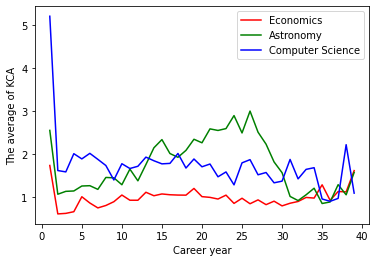

In [69]:
# for fig.5
x = [i for i in range(1, 40)]
# a (early bloomer)
eco_eb_kca = []
as_eb_kca = []
cs_eb_kca = []
for year in x:
    eco_kca_avg = as_kca_avg = cs_kca_avg = 0.0
    eco_count = as_count = cs_count = 0
    for author in early_bloomers_list[0]:
        if year in author_year_kca_list[0][author]:
            eco_kca_avg += author_year_kca_list[0][author][year]
            eco_count += 1
    for author in early_bloomers_list[1]:
        if year in author_year_kca_list[1][author]:
            as_kca_avg += author_year_kca_list[1][author][year]
            as_count += 1
    for author in early_bloomers_list[2]:
        if year in author_year_kca_list[2][author]:
            cs_kca_avg += author_year_kca_list[2][author][year]
            cs_count += 1
    eco_kca_avg /= eco_count
    eco_eb_kca.append(eco_kca_avg)
    as_kca_avg /= as_count
    as_eb_kca.append(as_kca_avg)
    cs_kca_avg /= cs_count
    cs_eb_kca.append(cs_kca_avg)

plt.plot(x, eco_eb_kca, color='r', label="Economics")
plt.plot(x, as_eb_kca, color='g', label="Astronomy")
plt.plot(x, cs_eb_kca, color='b', label="Computer Science")
plt.xlabel("Career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.savefig(save_path+"fig5(a).png")

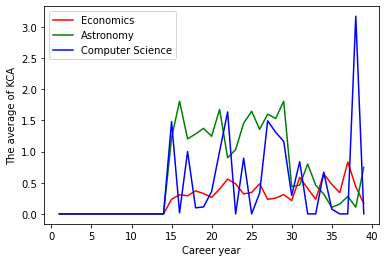

In [70]:
# b (mid bloomer)
eco_mb_kca = []
as_mb_kca = []
cs_mb_kca = []
for year in x:
    eco_kca_avg = as_kca_avg = cs_kca_avg = 0.0
    eco_count = as_count = cs_count = 0
    for author in mid_bloomers_list[0]:
        if year in author_year_kca_list[0][author]:
            eco_kca_avg += author_year_kca_list[0][author][year]
            eco_count += 1
    for author in mid_bloomers_list[1]:
        if year in author_year_kca_list[1][author]:
            as_kca_avg += author_year_kca_list[1][author][year]
            as_count += 1
    for author in mid_bloomers_list[2]:
        if year in author_year_kca_list[2][author]:
            cs_kca_avg += author_year_kca_list[2][author][year]
            cs_count += 1
    eco_kca_avg /= eco_count
    eco_mb_kca.append(eco_kca_avg)
    as_kca_avg /= as_count
    as_mb_kca.append(as_kca_avg)
    cs_kca_avg /= cs_count
    cs_mb_kca.append(cs_kca_avg)

plt.plot(x, eco_mb_kca, color='r', label="Economics")
plt.plot(x, as_mb_kca, color='g', label="Astronomy")
plt.plot(x, cs_mb_kca, color='b', label="Computer Science")
plt.xlabel("Career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.savefig(save_path+"fig5(b).png")

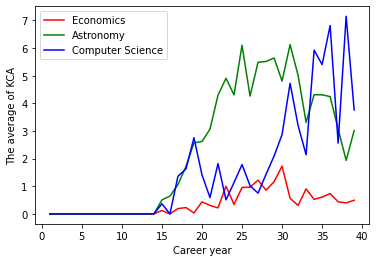

In [71]:
# c (late bloomer)
eco_lb_kca = []
as_lb_kca = []
cs_lb_kca = []
for year in x:
    eco_kca_avg = as_kca_avg = cs_kca_avg = 0.0
    eco_count = as_count = cs_count = 0
    for author in late_bloomers_list[0]:
        if year in author_year_kca_list[0][author]:
            eco_kca_avg += author_year_kca_list[0][author][year]
            eco_count += 1
    for author in late_bloomers_list[1]:
        if year in author_year_kca_list[1][author]:
            as_kca_avg += author_year_kca_list[1][author][year]
            as_count += 1
    for author in late_bloomers_list[2]:
        if year in author_year_kca_list[2][author]:
            cs_kca_avg += author_year_kca_list[2][author][year]
            cs_count += 1
    eco_kca_avg /= eco_count
    eco_lb_kca.append(eco_kca_avg)
    as_kca_avg /= as_count
    as_lb_kca.append(as_kca_avg)
    cs_kca_avg /= cs_count
    cs_lb_kca.append(cs_kca_avg)

plt.plot(x, eco_lb_kca, color='r', label="Economics")
plt.plot(x, as_lb_kca, color='g', label="Astronomy")
plt.plot(x, cs_lb_kca, color='b', label="Computer Science")
plt.xlabel("Career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.savefig(save_path+"fig5(c).png")

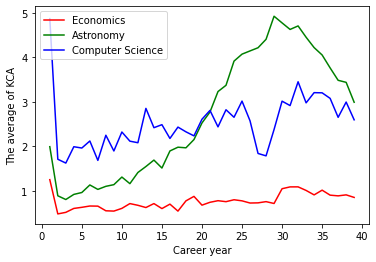

In [72]:
# d (second spring)
eco_ss_kca = []
as_ss_kca = []
cs_ss_kca = []
for year in x:
    eco_kca_avg = as_kca_avg = cs_kca_avg = 0.0
    eco_count = as_count = cs_count = 0
    for author in second_spring_list[0]:
        if year in author_year_kca_list[0][author]:
            eco_kca_avg += author_year_kca_list[0][author][year]
            eco_count += 1
    for author in second_spring_list[1]:
        if year in author_year_kca_list[1][author]:
            as_kca_avg += author_year_kca_list[1][author][year]
            as_count += 1
    for author in second_spring_list[2]:
        if year in author_year_kca_list[2][author]:
            cs_kca_avg += author_year_kca_list[2][author][year]
            cs_count += 1
    eco_kca_avg /= eco_count
    eco_ss_kca.append(eco_kca_avg)
    as_kca_avg /= as_count
    as_ss_kca.append(as_kca_avg)
    cs_kca_avg /= cs_count
    cs_ss_kca.append(cs_kca_avg)

plt.plot(x, eco_ss_kca, color='r', label="Economics")
plt.plot(x, as_ss_kca, color='g', label="Astronomy")
plt.plot(x, cs_ss_kca, color='b', label="Computer Science")
plt.xlabel("Career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.savefig(save_path+"fig5(d).png")

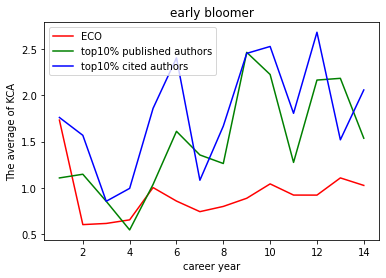

In [73]:
# for fig.6
x = [i for i in range(1, 15)]
eco_eb_kca1 = []
eco_eb_kca2 = []
eco_eb_kca3 = []
for year in x:
    eco_kca_avg1 = eco_kca_avg2 = eco_kca_avg3 = 0.0
    eco_count1 = eco_count2 = eco_count3 = 0
    for author in early_bloomers_list[0]:
        eco_kca_avg1 += author_year_kca_list[0][author][year]
        eco_count1 += 1
    early_bloomers_list[0] = sorted(early_bloomers_list[0], key=lambda a: len(author_papers_list[0][a]), reverse=True)
    for i in range(int(len(early_bloomers_list[0]) * 0.1)):
        author = early_bloomers_list[0][i]
        eco_kca_avg2 += author_year_kca_list[0][author][year]
        eco_count2 += 1
    early_bloomers_list[0] = sorted(early_bloomers_list[0], key=lambda a: len(author_cite_papers_list[0][a]), reverse=True)
    for i in range(int(len(early_bloomers_list[0]) * 0.1)):
        author = early_bloomers_list[0][i]
        eco_kca_avg3 += author_year_kca_list[0][author][year]
        eco_count3 += 1

    eco_kca_avg1 /= eco_count1
    eco_eb_kca1.append(eco_kca_avg1)
    eco_kca_avg2 /= eco_count2
    eco_eb_kca2.append(eco_kca_avg2)
    eco_kca_avg3 /= eco_count3
    eco_eb_kca3.append(eco_kca_avg3)

plt.plot(x, eco_eb_kca1, color='r', label="ECO")
plt.plot(x, eco_eb_kca2, color='g', label="top10% published authors")
plt.plot(x, eco_eb_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("early bloomer")
plt.savefig(save_path+"fig6(a).png")


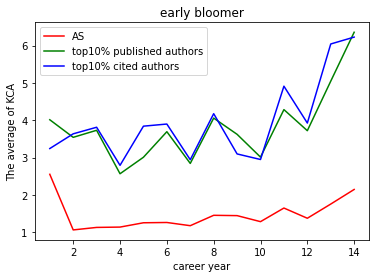

In [74]:
as_eb_kca1 = []
as_eb_kca2 = []
as_eb_kca3 = []
for year in x:
    as_kca_avg1 = as_kca_avg2 = as_kca_avg3 = 0.0
    as_count1 = as_count2 = as_count3 = 0
    for author in early_bloomers_list[1]:
        as_kca_avg1 += author_year_kca_list[1][author][year]
        as_count1 += 1
    early_bloomers_list[1] = sorted(early_bloomers_list[1], key=lambda a: len(author_papers_list[1][a]), reverse=True)
    for i in range(int(len(early_bloomers_list[1]) * 0.1)):
        author = early_bloomers_list[1][i]
        as_kca_avg2 += author_year_kca_list[1][author][year]
        as_count2 += 1
    early_bloomers_list[1] = sorted(early_bloomers_list[1], key=lambda a: len(author_cite_papers_list[1][a]), reverse=True)
    for i in range(int(len(early_bloomers_list[1]) * 0.1)):
        author = early_bloomers_list[1][i]
        as_kca_avg3 += author_year_kca_list[1][author][year]
        as_count3 += 1

    as_kca_avg1 /= as_count1
    as_eb_kca1.append(as_kca_avg1)
    as_kca_avg2 /= as_count2
    as_eb_kca2.append(as_kca_avg2)
    as_kca_avg3 /= as_count3
    as_eb_kca3.append(as_kca_avg3)

plt.plot(x, as_eb_kca1, color='r', label="AS")
plt.plot(x, as_eb_kca2, color='g', label="top10% published authors")
plt.plot(x, as_eb_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("early bloomer")
plt.savefig(save_path+"fig6(b).png")

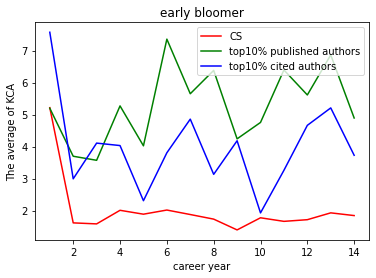

In [75]:
cs_eb_kca1 = []
cs_eb_kca2 = []
cs_eb_kca3 = []
for year in x:
    cs_kca_avg1 = cs_kca_avg2 = cs_kca_avg3 = 0.0
    cs_count1 = cs_count2 = cs_count3 = 0
    for author in early_bloomers_list[2]:
        cs_kca_avg1 += author_year_kca_list[2][author][year]
        cs_count1 += 1
    early_bloomers_list[2] = sorted(early_bloomers_list[2], key=lambda a: len(author_papers_list[2][a]), reverse=True)
    for i in range(int(len(early_bloomers_list[2]) * 0.1)):
        author = early_bloomers_list[2][i]
        cs_kca_avg2 += author_year_kca_list[2][author][year]
        cs_count2 += 1
    early_bloomers_list[2] = sorted(early_bloomers_list[2], key=lambda a: len(author_cite_papers_list[2][a]), reverse=True)
    for i in range(int(len(early_bloomers_list[2]) * 0.1)):
        author = early_bloomers_list[2][i]
        cs_kca_avg3 += author_year_kca_list[2][author][year]
        cs_count3 += 1

    cs_kca_avg1 /= cs_count1
    cs_eb_kca1.append(cs_kca_avg1)
    cs_kca_avg2 /= cs_count2
    cs_eb_kca2.append(cs_kca_avg2)
    cs_kca_avg3 /= cs_count3
    cs_eb_kca3.append(cs_kca_avg3)

plt.plot(x, cs_eb_kca1, color='r', label="CS")
plt.plot(x, cs_eb_kca2, color='g', label="top10% published authors")
plt.plot(x, cs_eb_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("early bloomer")
plt.savefig(save_path+"fig6(c).png")

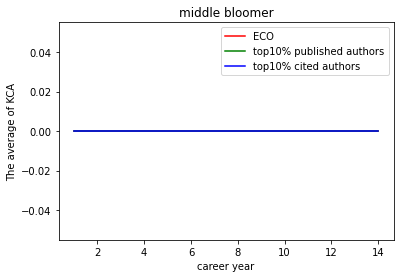

In [76]:
# for fig.7
x = [i for i in range(1, 15)]
eco_mb_kca1 = []
eco_mb_kca2 = []
eco_mb_kca3 = []
for year in x:
    eco_kca_avg1 = eco_kca_avg2 = eco_kca_avg3 = 0.0
    eco_count1 = eco_count2 = eco_count3 = 0
    for author in mid_bloomers_list[0]:
        eco_kca_avg1 += author_year_kca_list[0][author][year]
        eco_count1 += 1
    mid_bloomers_list[0] = sorted(mid_bloomers_list[0], key=lambda a: len(author_papers_list[0][a]), reverse=True)
    for i in range(int(len(mid_bloomers_list[0]) * 0.1)):
        author = mid_bloomers_list[0][i]
        eco_kca_avg2 += author_year_kca_list[0][author][year]
        eco_count2 += 1
    mid_bloomers_list[0] = sorted(mid_bloomers_list[0], key=lambda a: len(author_cite_papers_list[0][a]), reverse=True)
    for i in range(int(len(mid_bloomers_list[0]) * 0.1)):
        author = mid_bloomers_list[0][i]
        eco_kca_avg3 += author_year_kca_list[0][author][year]
        eco_count3 += 1

    eco_kca_avg1 /= eco_count1
    eco_mb_kca1.append(eco_kca_avg1)
    eco_kca_avg2 /= eco_count2
    eco_mb_kca2.append(eco_kca_avg2)
    eco_kca_avg3 /= eco_count3
    eco_mb_kca3.append(eco_kca_avg3)

plt.plot(x, eco_mb_kca1, color='r', label="ECO")
plt.plot(x, eco_mb_kca2, color='g', label="top10% published authors")
plt.plot(x, eco_mb_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("middle bloomer")
plt.savefig(save_path+"fig7(a).png")

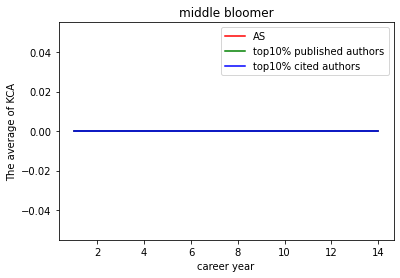

In [77]:
as_mb_kca1 = []
as_mb_kca2 = []
as_mb_kca3 = []
for year in x:
    as_kca_avg1 = as_kca_avg2 = as_kca_avg3 = 0.0
    as_count1 = as_count2 = as_count3 = 0
    for author in mid_bloomers_list[1]:
        as_kca_avg1 += author_year_kca_list[1][author][year]
        as_count1 += 1
    mid_bloomers_list[1] = sorted(mid_bloomers_list[1], key=lambda a: len(author_papers_list[1][a]), reverse=True)
    for i in range(int(len(mid_bloomers_list[1]) * 0.1)):
        author = mid_bloomers_list[1][i]
        as_kca_avg2 += author_year_kca_list[1][author][year]
        as_count2 += 1
    mid_bloomers_list[1] = sorted(mid_bloomers_list[1], key=lambda a: len(author_cite_papers_list[1][a]), reverse=True)
    for i in range(int(len(mid_bloomers_list[1]) * 0.1)):
        author = mid_bloomers_list[1][i]
        as_kca_avg3 += author_year_kca_list[1][author][year]
        as_count3 += 1

    as_kca_avg1 /= as_count1
    as_mb_kca1.append(as_kca_avg1)
    as_kca_avg2 /= as_count2
    as_mb_kca2.append(as_kca_avg2)
    as_kca_avg3 /= as_count3
    as_mb_kca3.append(as_kca_avg3)

plt.plot(x, as_mb_kca1, color='r', label="AS")
plt.plot(x, as_mb_kca2, color='g', label="top10% published authors")
plt.plot(x, as_mb_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("middle bloomer")
plt.savefig(save_path+"fig7(b).png")

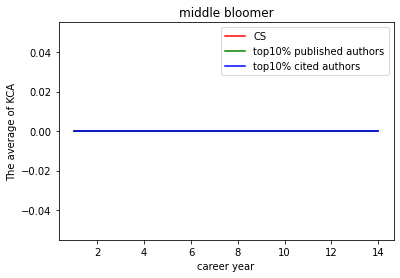

In [78]:
cs_mb_kca1 = []
cs_mb_kca2 = []
cs_mb_kca3 = []
for year in x:
    cs_kca_avg1 = cs_kca_avg2 = cs_kca_avg3 = 0.0
    cs_count1 = cs_count2 = cs_count3 = 0
    for author in mid_bloomers_list[2]:
        cs_kca_avg1 += author_year_kca_list[2][author][year]
        cs_count1 += 1
    mid_bloomers_list[2] = sorted(mid_bloomers_list[2], key=lambda a: len(author_papers_list[2][a]), reverse=True)
    for i in range(int(len(mid_bloomers_list[2]) * 0.1)):
        author = mid_bloomers_list[2][i]
        cs_kca_avg2 += author_year_kca_list[2][author][year]
        cs_count2 += 1
    mid_bloomers_list[2] = sorted(mid_bloomers_list[2], key=lambda a: len(author_cite_papers_list[2][a]), reverse=True)
    for i in range(int(len(mid_bloomers_list[2]) * 0.1)):
        author = mid_bloomers_list[2][i]
        cs_kca_avg3 += author_year_kca_list[2][author][year]
        cs_count3 += 1

    cs_kca_avg1 /= cs_count1
    cs_mb_kca1.append(cs_kca_avg1)
    cs_kca_avg2 /= cs_count2
    cs_mb_kca2.append(cs_kca_avg2)
    cs_kca_avg3 /= cs_count3
    cs_mb_kca3.append(cs_kca_avg3)

plt.plot(x, cs_mb_kca1, color='r', label="CS")
plt.plot(x, cs_mb_kca2, color='g', label="top10% published authors")
plt.plot(x, cs_mb_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("middle bloomer")
plt.savefig(save_path+"fig6(c).png")

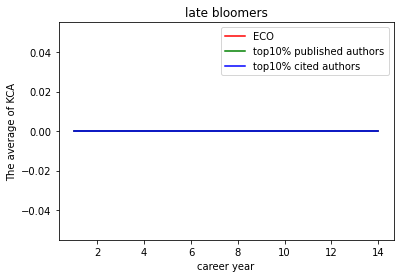

In [79]:
# for fig.8
x = [i for i in range(1, 15)]
eco_lb_kca1 = []
eco_lb_kca2 = []
eco_lb_kca3 = []
for year in x:
    eco_kca_avg1 = eco_kca_avg2 = eco_kca_avg3 = 0.0
    eco_count1 = eco_count2 = eco_count3 = 0
    for author in late_bloomers_list[0]:
        eco_kca_avg1 += author_year_kca_list[0][author][year]
        eco_count1 += 1
    late_bloomers_list[0] = sorted(late_bloomers_list[0], key=lambda a: len(author_papers_list[0][a]), reverse=True)
    for i in range(int(len(late_bloomers_list[0]) * 0.1)):
        author = late_bloomers_list[0][i]
        eco_kca_avg2 += author_year_kca_list[0][author][year]
        eco_count2 += 1
    late_bloomers_list[0] = sorted(late_bloomers_list[0], key=lambda a: len(author_cite_papers_list[0][a]), reverse=True)
    for i in range(int(len(late_bloomers_list[0]) * 0.1)):
        author = late_bloomers_list[0][i]
        eco_kca_avg3 += author_year_kca_list[0][author][year]
        eco_count3 += 1

    eco_kca_avg1 /= eco_count1
    eco_lb_kca1.append(eco_kca_avg1)
    eco_kca_avg2 /= eco_count2
    eco_lb_kca2.append(eco_kca_avg2)
    eco_kca_avg3 /= eco_count3
    eco_lb_kca3.append(eco_kca_avg3)

plt.plot(x, eco_lb_kca1, color='r', label="ECO")
plt.plot(x, eco_lb_kca2, color='g', label="top10% published authors")
plt.plot(x, eco_lb_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("late bloomers")
plt.savefig("fig8(a).png")

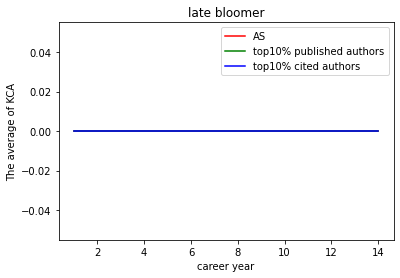

In [80]:
as_lb_kca1 = []
as_lb_kca2 = []
as_lb_kca3 = []
for year in x:
    as_kca_avg1 = as_kca_avg2 = as_kca_avg3 = 0.0
    as_count1 = as_count2 = as_count3 = 0
    for author in late_bloomers_list[1]:
        as_kca_avg1 += author_year_kca_list[1][author][year]
        as_count1 += 1
    late_bloomers_list[1] = sorted(late_bloomers_list[1], key=lambda a: len(author_papers_list[1][a]), reverse=True)
    for i in range(int(len(late_bloomers_list[1]) * 0.1)):
        author = late_bloomers_list[1][i]
        as_kca_avg2 += author_year_kca_list[1][author][year]
        as_count2 += 1
    late_bloomers_list[1] = sorted(late_bloomers_list[1], key=lambda a: len(author_cite_papers_list[1][a]), reverse=True)
    for i in range(int(len(late_bloomers_list[1]) * 0.1)):
        author = late_bloomers_list[1][i]
        as_kca_avg3 += author_year_kca_list[1][author][year]
        as_count3 += 1

    as_kca_avg1 /= as_count1
    as_lb_kca1.append(as_kca_avg1)
    as_kca_avg2 /= as_count2
    as_lb_kca2.append(as_kca_avg2)
    as_kca_avg3 /= as_count3
    as_lb_kca3.append(as_kca_avg3)

plt.plot(x, as_lb_kca1, color='r', label="AS")
plt.plot(x, as_lb_kca2, color='g', label="top10% published authors")
plt.plot(x, as_lb_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("late bloomer")
plt.savefig(save_path+"fig8(b).png")

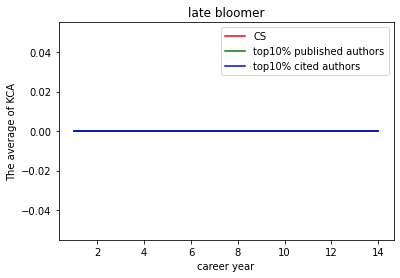

In [81]:
cs_lb_kca1 = []
cs_lb_kca2 = []
cs_lb_kca3 = []
for year in x:
    cs_kca_avg1 = cs_kca_avg2 = cs_kca_avg3 = 0.0
    cs_count1 = cs_count2 = cs_count3 = 0
    for author in late_bloomers_list[2]:
        cs_kca_avg1 += author_year_kca_list[2][author][year]
        cs_count1 += 1
    late_bloomers_list[2] = sorted(late_bloomers_list[2], key=lambda a: len(author_papers_list[2][a]), reverse=True)
    for i in range(int(len(late_bloomers_list[2]) * 0.1)):
        author = late_bloomers_list[2][i]
        cs_kca_avg2 += author_year_kca_list[2][author][year]
        cs_count2 += 1
    late_bloomers_list[2] = sorted(late_bloomers_list[2], key=lambda a: len(author_cite_papers_list[2][a]), reverse=True)
    for i in range(int(len(late_bloomers_list[2]) * 0.1)):
        author = late_bloomers_list[2][i]
        cs_kca_avg3 += author_year_kca_list[2][author][year]
        cs_count3 += 1

    cs_kca_avg1 /= cs_count1
    cs_lb_kca1.append(cs_kca_avg1)
    cs_kca_avg2 /= cs_count2
    cs_lb_kca2.append(cs_kca_avg2)
    cs_kca_avg3 /= cs_count3
    cs_lb_kca3.append(cs_kca_avg3)

plt.plot(x, cs_lb_kca1, color='r', label="CS")
plt.plot(x, cs_lb_kca2, color='g', label="top10% published authors")
plt.plot(x, cs_lb_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("late bloomer")
plt.savefig(save_path+"fig8(c).png")

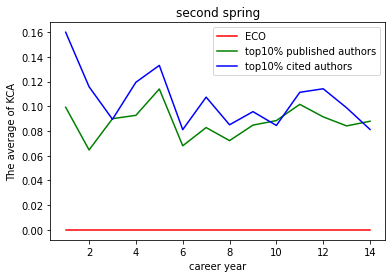

In [83]:
# for fig.9
x = [i for i in range(1, 15)]

eco_ss_kca1 = []
eco_ss_kca2 = []
eco_ss_kca3 = []
for year in x:
    as_kca_avg1 = as_kca_avg2 = eco_kca_avg3 = 0.0
    as_count1 = as_count2 = cs_count3 = 0
    for author in second_spring_list[0]:
        cs_kca_avg1 += author_year_kca_list[0][author][year]
        cs_count1 += 1
    second_spring_list[0] = sorted(second_spring_list[0], key=lambda a: len(author_papers_list[0][a]), reverse=True)
    for i in range(int(len(second_spring_list[0]) * 0.1)):
        author = second_spring_list[0][i]
        eco_kca_avg2 += author_year_kca_list[0][author][year]
        eco_count2 += 1
    second_spring_list[0] = sorted(second_spring_list[0], key=lambda a: len(author_cite_papers_list[0][a]), reverse=True)
    for i in range(int(len(second_spring_list[0]) * 0.1)):
        author = second_spring_list[0][i]
        eco_kca_avg3 += author_year_kca_list[0][author][year]
        eco_count3 += 1

    eco_kca_avg1 /= eco_count1
    eco_ss_kca1.append(eco_kca_avg1)
    eco_kca_avg2 /= eco_count2
    eco_ss_kca2.append(eco_kca_avg2)
    eco_kca_avg3 /= eco_count3
    eco_ss_kca3.append(eco_kca_avg3)

plt.plot(x, eco_ss_kca1, color='r', label="ECO")
plt.plot(x, eco_ss_kca2, color='g', label="top10% published authors")
plt.plot(x, eco_ss_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("second spring")
plt.savefig(save_path+"fig9(a).png")

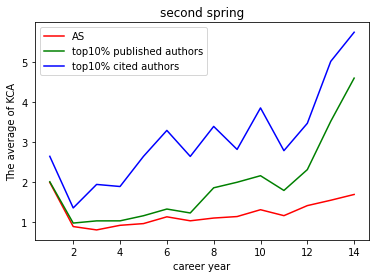

In [84]:
as_ss_kca1 = []
as_ss_kca2 = []
as_ss_kca3 = []
for year in x:
    as_kca_avg1 = as_kca_avg2 = as_kca_avg3 = 0.0
    as_count1 = as_count2 = as_count3 = 0
    for author in second_spring_list[1]:
        as_kca_avg1 += author_year_kca_list[1][author][year]
        as_count1 += 1
    second_spring_list[1] = sorted(second_spring_list[1], key=lambda a: len(author_papers_list[1][a]), reverse=True)
    for i in range(int(len(second_spring_list[1]) * 0.1)):
        author = second_spring_list[1][i]
        as_kca_avg2 += author_year_kca_list[1][author][year]
        as_count2 += 1
    second_spring_list[1] = sorted(second_spring_list[1], key=lambda a: len(author_cite_papers_list[1][a]), reverse=True)
    for i in range(int(len(second_spring_list[1]) * 0.1)):
        author = second_spring_list[1][i]
        as_kca_avg3 += author_year_kca_list[1][author][year]
        as_count3 += 1

    as_kca_avg1 /= as_count1
    as_ss_kca1.append(as_kca_avg1)
    as_kca_avg2 /= as_count2
    as_ss_kca2.append(as_kca_avg2)
    as_kca_avg3 /= as_count3
    as_ss_kca3.append(as_kca_avg3)

plt.plot(x, as_ss_kca1, color='r', label="AS")
plt.plot(x, as_ss_kca2, color='g', label="top10% published authors")
plt.plot(x, as_ss_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("second spring")
plt.savefig(save_path+"fig9(b).png")

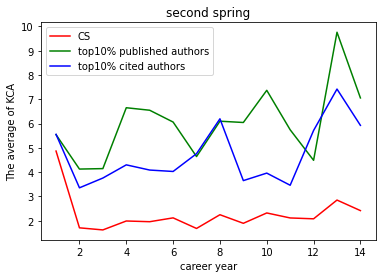

In [85]:
cs_ss_kca1 = []
cs_ss_kca2 = []
cs_ss_kca3 = []
for year in x:
    cs_kca_avg1 = cs_kca_avg2 = cs_kca_avg3 = 0.0
    cs_count1 = cs_count2 = cs_count3 = 0
    for author in second_spring_list[2]:
        cs_kca_avg1 += author_year_kca_list[2][author][year]
        cs_count1 += 1
    second_spring_list[2] = sorted(second_spring_list[2], key=lambda a: len(author_papers_list[2][a]), reverse=True)
    for i in range(int(len(second_spring_list[2]) * 0.1)):
        author = second_spring_list[2][i]
        cs_kca_avg2 += author_year_kca_list[2][author][year]
        cs_count2 += 1
    second_spring_list[2] = sorted(second_spring_list[2], key=lambda a: len(author_cite_papers_list[2][a]), reverse=True)
    for i in range(int(len(second_spring_list[2]) * 0.1)):
        author = second_spring_list[2][i]
        cs_kca_avg3 += author_year_kca_list[2][author][year]
        cs_count3 += 1

    cs_kca_avg1 /= cs_count1
    cs_ss_kca1.append(cs_kca_avg1)
    cs_kca_avg2 /= cs_count2
    cs_ss_kca2.append(cs_kca_avg2)
    cs_kca_avg3 /= cs_count3
    cs_ss_kca3.append(cs_kca_avg3)

plt.plot(x, cs_ss_kca1, color='r', label="CS")
plt.plot(x, cs_ss_kca2, color='g', label="top10% published authors")
plt.plot(x, cs_ss_kca3, color='b', label="top10% cited authors")
plt.xlabel("career year")
plt.ylabel("The average of KCA")
plt.legend(loc="best")
plt.title("second spring")
plt.savefig(save_path+"fig9(c).png")